# Mask R-CNN Demo

A quick intro to using the pre-trained model to detect and segment objects.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
DRIVE_PATH = "/content/drive/MyDrive/MTechCSE_2020/Term_Paper/Sem_6_analysis/MaskRCNN_AD"

In [4]:
# Root directory of the project
CURR_DIR = "/content/MRCNN"

In [5]:
!rm -rf CURR_DIR

In [6]:
import shutil
import os
import sys
def loadToMemory():
  if not os.path.exists(CURR_DIR):
    shutil.copytree(DRIVE_PATH, CURR_DIR)
  else:
      print(f"MaskRCNN Folder exsist")

In [7]:
loadToMemory()

In [8]:
import os
os.chdir('./MRCNN')
os.getcwd()

'/content/MRCNN'

In [9]:
!ls

brain_tumor_images	   LICENSE	      mrcnn		setup.cfg
brain_tumor_images_old	   MANIFEST.in	      README.md		setup.py
BrainTumor_MaskRCNN.ipynb  mask_rcnn_coco.h5  requirements.txt


In [10]:
from google.colab import drive
drive.flush_and_unmount()

In [ ]:
!pip install -r requirements.txt

In [ ]:
!python3 setup.py install

In [13]:
import tensorflow as tf
print(tf.__version__)

import keras as ke
print(ke.__version__)

2.8.0
2.8.0


In [ ]:
# shutil.rmtree('/content/MRCNN/logs/', ignore_errors=True)

In [14]:
# DATASET_DIR = "./brain_tumor_images"
DATASET_DIR = "./brain_tumor_images_old/data_cleaned"

!ls $DATASET_DIR

annotations_all.json  test  train  val


In [15]:
# Import Mask RCNN
# Root directory of the project
# ROOT_DIR = os.path.abspath("../")

# Import Mask RCNN
# sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn.config import Config
from mrcnn import model as modellib, utils

# Path to trained weights file
COCO_WEIGHTS_PATH = os.path.join(os.getcwd(), "mask_rcnn_coco.h5")
# Local path to trained weights file
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_WEIGHTS_PATH):
    utils.download_trained_weights(COCO_WEIGHTS_PATH)
else:
     print(f"WEIGHTS found")
# Directory to save logs and model checkpoints, if not provided
# through the command line argument --logs
DEFAULT_LOGS_DIR = os.path.join(os.getcwd(), "logs")

/content/MRCNN/mrcnn/model.py:2368: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if os.name is 'nt':


WEIGHTS found


In [ ]:
class CustomConfig(Config):
    """Configuration for training on the custom  dataset.
    Derives from the base Config class and overrides some values.
    """
    # Give the configuration a recognizable name
    NAME = "object" #    NAME = 'tumor_detector'

    GPU_COUNT = 1

    # We use a GPU with 12GB memory, which can fit two images.
    # Adjust down if you use a smaller GPU.
    IMAGES_PER_GPU = 1

    # Number of classes (including background)
    NUM_CLASSES = 1 + 1  # Background + tumour

    # Number of training steps per epoch
    STEPS_PER_EPOCH = 100
    # VALIDATION_STEPS = 10
    # STEPS_PER_EPOCH = 100
    # Skip detections with < 90% confidence
    DETECTION_MIN_CONFIDENCE = 0.9

    LEARNING_RATE = 0.001

config = CustomConfig()
config.display()

In [17]:
import os
import sys
import json
import datetime
import numpy as np
import skimage.draw
import cv2
from mrcnn.visualize import display_instances
import matplotlib.pyplot as plt


class BrainScanDataset(utils.Dataset):

    def load_brain_scan(self, dataset_dir, subset):
        """Load a subset of the FarmCow dataset.
        dataset_dir: Root directory of the dataset.
        subset: Subset to load: train or val
        """
        # Add classes. We have only one class to add.
        self.add_class("tumor", 1, "tumor")

        # Train or validation dataset?
        assert subset in ["train", "val", 'test']
        dataset_dir = os.path.join(dataset_dir, subset)

        annotations = json.load(open(os.path.join(DATASET_DIR, subset, 'annotations_'+subset+'.json')))
        annotations = list(annotations.values())  # don't need the dict keys

        # The VIA tool saves images in the JSON even if they don't have any
        # annotations. Skip unannotated images.
        annotations = [a for a in annotations if a['regions']]

        # Add images
        for a in annotations:
            # Get the x, y coordinaets of points of the polygons that make up
            # the outline of each object instance. These are stores in the
            # shape_attributes (see json format above)
            # The if condition is needed to support VIA versions 1.x and 2.x.
            if type(a['regions']) is dict:
                polygons = [r['shape_attributes'] for r in a['regions'].values()]
            else:
                polygons = [r['shape_attributes'] for r in a['regions']]

            # load_mask() needs the image size to convert polygons to masks.
            # Unfortunately, VIA doesn't include it in JSON, so we must read
            # the image. This is only managable since the dataset is tiny.
            image_path = os.path.join(dataset_dir, a['filename'])
            image = skimage.io.imread(image_path)
            height, width = image.shape[:2]

            self.add_image(
                "tumor",
                image_id=a['filename'],  # use file name as a unique image id
                path=image_path,
                width=width,
                height=height,
                polygons=polygons
            )

    def load_mask(self, image_id):
        """Generate instance masks for an image.
       Returns:
        masks: A bool array of shape [height, width, instance count] with
            one mask per instance.
        class_ids: a 1D array of class IDs of the instance masks.
        """
        # If not a farm_cow dataset image, delegate to parent class.
        image_info = self.image_info[image_id]
        if image_info["source"] != "tumor":
            return super(self.__class__, self).load_mask(image_id)

        # Convert polygons to a bitmap mask of shape
        # [height, width, instance_count]
        info = self.image_info[image_id]
        mask = np.zeros([info["height"], info["width"], len(info["polygons"])],
                        dtype=np.uint8)
        for i, p in enumerate(info["polygons"]):
            # Get indexes of pixels inside the polygon and set them to 1
            rr, cc = skimage.draw.polygon(p['all_points_y'], p['all_points_x'])
            mask[rr, cc, i] = 1

        # Return mask, and array of class IDs of each instance. Since we have
        # one class ID only, we return an array of 1s
        return mask.astype(np.bool), np.ones([mask.shape[-1]], dtype=np.int32)

    def image_reference(self, image_id):
        """Return the path of the image."""
        info = self.image_info[image_id]
        if info["source"] == "tumor":
            return info["path"]
        else:
            super(self.__class__, self).image_reference(image_id)


In [18]:
model = modellib.MaskRCNN(
    mode='training',
    config=config,
    model_dir=DEFAULT_LOGS_DIR
)

model.load_weights(
    COCO_WEIGHTS_PATH,
    by_name=True,
    exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", "mrcnn_bbox", "mrcnn_mask"]
)

In [ ]:
# Training dataset.
dataset_train = BrainScanDataset()
dataset_train.load_brain_scan(DATASET_DIR, 'train')
dataset_train.prepare()

# Validation dataset
dataset_val = BrainScanDataset()
dataset_val.load_brain_scan(DATASET_DIR, 'val')
dataset_val.prepare()

dataset_test = BrainScanDataset()
dataset_test.load_brain_scan(DATASET_DIR, 'test')
dataset_test.prepare()

# Since we're using a very small dataset, and starting from
# COCO trained weights, we don't need to train too long. Also,
# no need to train all layers, just the heads should do it.
print("Training network heads")
model.train(
    dataset_train, dataset_val,
    learning_rate=config.LEARNING_RATE,
    epochs=5,
    layers='heads'
)

Training network heads

Starting at epoch 0. LR=0.001

Checkpoint Path: /content/MRCNN/logs/object20230707T1841/mask_rcnn_object_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
rpn_model              (Functional)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrcnn_mask_bn4         (TimeDistributed)
mrcnn_bbox_fc          (TimeDistributed)
mrcnn

/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


NB workers 2


<ipython-input-17-b517cf02fabd>:84: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return mask.astype(np.bool), np.ones([mask.shape[-1]], dtype=np.int32)
/usr/local/lib/python3.10/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
<ipython-input-17-b517cf02fabd>:84: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use 

Epoch 1/5


/usr/local/lib/python3.10/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
<ipython-input-17-b517cf02fabd>:84: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return mask.astype(np.bool), np.ones([mask.shape[-1]], dtype=np.int32)
/usr/local/lib/python3.10/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defin

  1/100 [..............................] - ETA: 2:31:28 - batch: 0.0000e+00 - size: 1.0000 - loss: 29.8111 - rpn_class_loss: 1.4633 - rpn_bbox_loss: 15.1708 - mrcnn_class_loss: 13.1771 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

<ipython-input-17-b517cf02fabd>:84: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return mask.astype(np.bool), np.ones([mask.shape[-1]], dtype=np.int32)
/usr/local/lib/python3.10/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  2/100 [..............................] - ETA: 1:39:26 - batch: 0.5000 - size: 1.0000 - loss: 43.6530 - rpn_class_loss: 1.1251 - rpn_bbox_loss: 34.7110 - mrcnn_class_loss: 7.8169 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00     

<ipython-input-17-b517cf02fabd>:84: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return mask.astype(np.bool), np.ones([mask.shape[-1]], dtype=np.int32)
/usr/local/lib/python3.10/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  3/100 [..............................] - ETA: 1:38:13 - batch: 1.0000 - size: 1.0000 - loss: 32.0178 - rpn_class_loss: 0.9837 - rpn_bbox_loss: 25.8229 - mrcnn_class_loss: 5.2113 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

<ipython-input-17-b517cf02fabd>:84: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return mask.astype(np.bool), np.ones([mask.shape[-1]], dtype=np.int32)
/usr/local/lib/python3.10/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  4/100 [>.............................] - ETA: 1:39:52 - batch: 1.5000 - size: 1.0000 - loss: 24.9484 - rpn_class_loss: 0.8729 - rpn_bbox_loss: 20.1671 - mrcnn_class_loss: 3.9084 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

<ipython-input-17-b517cf02fabd>:84: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return mask.astype(np.bool), np.ones([mask.shape[-1]], dtype=np.int32)
/usr/local/lib/python3.10/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  5/100 [>.............................] - ETA: 1:37:27 - batch: 2.0000 - size: 1.0000 - loss: 31.6580 - rpn_class_loss: 1.7622 - rpn_bbox_loss: 23.3784 - mrcnn_class_loss: 3.1772 - mrcnn_bbox_loss: 3.1010 - mrcnn_mask_loss: 0.2392        

<ipython-input-17-b517cf02fabd>:84: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return mask.astype(np.bool), np.ones([mask.shape[-1]], dtype=np.int32)
/usr/local/lib/python3.10/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  6/100 [>.............................] - ETA: 1:36:07 - batch: 2.5000 - size: 1.0000 - loss: 28.6213 - rpn_class_loss: 1.5546 - rpn_bbox_loss: 21.6355 - mrcnn_class_loss: 2.6477 - mrcnn_bbox_loss: 2.5841 - mrcnn_mask_loss: 0.1993

<ipython-input-17-b517cf02fabd>:84: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return mask.astype(np.bool), np.ones([mask.shape[-1]], dtype=np.int32)
/usr/local/lib/python3.10/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  7/100 [=>............................] - ETA: 1:35:22 - batch: 3.0000 - size: 1.0000 - loss: 28.1954 - rpn_class_loss: 1.4914 - rpn_bbox_loss: 21.5487 - mrcnn_class_loss: 2.2707 - mrcnn_bbox_loss: 2.5995 - mrcnn_mask_loss: 0.2852

<ipython-input-17-b517cf02fabd>:84: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return mask.astype(np.bool), np.ones([mask.shape[-1]], dtype=np.int32)
/usr/local/lib/python3.10/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  8/100 [=>............................] - ETA: 1:35:47 - batch: 3.5000 - size: 1.0000 - loss: 26.3561 - rpn_class_loss: 1.3620 - rpn_bbox_loss: 20.4833 - mrcnn_class_loss: 1.9868 - mrcnn_bbox_loss: 2.2745 - mrcnn_mask_loss: 0.2495

<ipython-input-17-b517cf02fabd>:84: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return mask.astype(np.bool), np.ones([mask.shape[-1]], dtype=np.int32)
/usr/local/lib/python3.10/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  9/100 [=>............................] - ETA: 1:34:16 - batch: 4.0000 - size: 1.0000 - loss: 25.0521 - rpn_class_loss: 1.2889 - rpn_bbox_loss: 19.7535 - mrcnn_class_loss: 1.7661 - mrcnn_bbox_loss: 2.0218 - mrcnn_mask_loss: 0.2218

<ipython-input-17-b517cf02fabd>:84: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return mask.astype(np.bool), np.ones([mask.shape[-1]], dtype=np.int32)
/usr/local/lib/python3.10/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 10/100 [==>...........................] - ETA: 1:33:07 - batch: 4.5000 - size: 1.0000 - loss: 23.6644 - rpn_class_loss: 1.2681 - rpn_bbox_loss: 18.7876 - mrcnn_class_loss: 1.5895 - mrcnn_bbox_loss: 1.8196 - mrcnn_mask_loss: 0.1996

<ipython-input-17-b517cf02fabd>:84: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return mask.astype(np.bool), np.ones([mask.shape[-1]], dtype=np.int32)
/usr/local/lib/python3.10/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 11/100 [==>...........................] - ETA: 1:32:02 - batch: 5.0000 - size: 1.0000 - loss: 23.1889 - rpn_class_loss: 1.1545 - rpn_bbox_loss: 17.5455 - mrcnn_class_loss: 1.4517 - mrcnn_bbox_loss: 2.7422 - mrcnn_mask_loss: 0.2950

<ipython-input-17-b517cf02fabd>:84: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return mask.astype(np.bool), np.ones([mask.shape[-1]], dtype=np.int32)
/usr/local/lib/python3.10/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 12/100 [==>...........................] - ETA: 1:30:41 - batch: 5.5000 - size: 1.0000 - loss: 22.2078 - rpn_class_loss: 1.0671 - rpn_bbox_loss: 17.0260 - mrcnn_class_loss: 1.3308 - mrcnn_bbox_loss: 2.5137 - mrcnn_mask_loss: 0.2704

<ipython-input-17-b517cf02fabd>:84: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return mask.astype(np.bool), np.ones([mask.shape[-1]], dtype=np.int32)
/usr/local/lib/python3.10/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 13/100 [==>...........................] - ETA: 1:29:19 - batch: 6.0000 - size: 1.0000 - loss: 23.5794 - rpn_class_loss: 1.1294 - rpn_bbox_loss: 16.7341 - mrcnn_class_loss: 1.2702 - mrcnn_bbox_loss: 4.0412 - mrcnn_mask_loss: 0.4045

<ipython-input-17-b517cf02fabd>:84: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return mask.astype(np.bool), np.ones([mask.shape[-1]], dtype=np.int32)
/usr/local/lib/python3.10/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 14/100 [===>..........................] - ETA: 1:28:30 - batch: 6.5000 - size: 1.0000 - loss: 24.8303 - rpn_class_loss: 1.0795 - rpn_bbox_loss: 18.4433 - mrcnn_class_loss: 1.1794 - mrcnn_bbox_loss: 3.7526 - mrcnn_mask_loss: 0.3756

<ipython-input-17-b517cf02fabd>:84: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return mask.astype(np.bool), np.ones([mask.shape[-1]], dtype=np.int32)
/usr/local/lib/python3.10/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 15/100 [===>..........................] - ETA: 1:27:09 - batch: 7.0000 - size: 1.0000 - loss: 27.1608 - rpn_class_loss: 1.0719 - rpn_bbox_loss: 21.1351 - mrcnn_class_loss: 1.1008 - mrcnn_bbox_loss: 3.5024 - mrcnn_mask_loss: 0.3505

<ipython-input-17-b517cf02fabd>:84: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return mask.astype(np.bool), np.ones([mask.shape[-1]], dtype=np.int32)
/usr/local/lib/python3.10/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 16/100 [===>..........................] - ETA: 1:25:33 - batch: 7.5000 - size: 1.0000 - loss: 26.2198 - rpn_class_loss: 1.0202 - rpn_bbox_loss: 20.5555 - mrcnn_class_loss: 1.0320 - mrcnn_bbox_loss: 3.2835 - mrcnn_mask_loss: 0.3286

<ipython-input-17-b517cf02fabd>:84: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return mask.astype(np.bool), np.ones([mask.shape[-1]], dtype=np.int32)
/usr/local/lib/python3.10/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 17/100 [====>.........................] - ETA: 1:24:41 - batch: 8.0000 - size: 1.0000 - loss: 26.2299 - rpn_class_loss: 0.9654 - rpn_bbox_loss: 20.8936 - mrcnn_class_loss: 0.9713 - mrcnn_bbox_loss: 3.0904 - mrcnn_mask_loss: 0.3093

<ipython-input-17-b517cf02fabd>:84: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return mask.astype(np.bool), np.ones([mask.shape[-1]], dtype=np.int32)
/usr/local/lib/python3.10/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 18/100 [====>.........................] - ETA: 1:24:01 - batch: 8.5000 - size: 1.0000 - loss: 25.3419 - rpn_class_loss: 0.9586 - rpn_bbox_loss: 20.2551 - mrcnn_class_loss: 0.9173 - mrcnn_bbox_loss: 2.9187 - mrcnn_mask_loss: 0.2921

<ipython-input-17-b517cf02fabd>:84: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return mask.astype(np.bool), np.ones([mask.shape[-1]], dtype=np.int32)
/usr/local/lib/python3.10/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 19/100 [====>.........................] - ETA: 1:23:06 - batch: 9.0000 - size: 1.0000 - loss: 24.5062 - rpn_class_loss: 0.9090 - rpn_bbox_loss: 19.2907 - mrcnn_class_loss: 0.8712 - mrcnn_bbox_loss: 3.1194 - mrcnn_mask_loss: 0.3159

<ipython-input-17-b517cf02fabd>:84: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return mask.astype(np.bool), np.ones([mask.shape[-1]], dtype=np.int32)
/usr/local/lib/python3.10/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 20/100 [=====>........................] - ETA: 1:22:15 - batch: 9.5000 - size: 1.0000 - loss: 24.2724 - rpn_class_loss: 0.8639 - rpn_bbox_loss: 18.5742 - mrcnn_class_loss: 0.8358 - mrcnn_bbox_loss: 3.6536 - mrcnn_mask_loss: 0.3449

<ipython-input-17-b517cf02fabd>:84: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return mask.astype(np.bool), np.ones([mask.shape[-1]], dtype=np.int32)
/usr/local/lib/python3.10/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 21/100 [=====>........................] - ETA: 1:21:31 - batch: 10.0000 - size: 1.0000 - loss: 23.5838 - rpn_class_loss: 0.8229 - rpn_bbox_loss: 17.8603 - mrcnn_class_loss: 0.7967 - mrcnn_bbox_loss: 3.7428 - mrcnn_mask_loss: 0.3610

<ipython-input-17-b517cf02fabd>:84: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return mask.astype(np.bool), np.ones([mask.shape[-1]], dtype=np.int32)
/usr/local/lib/python3.10/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 22/100 [=====>........................] - ETA: 1:20:15 - batch: 10.5000 - size: 1.0000 - loss: 23.6139 - rpn_class_loss: 0.8403 - rpn_bbox_loss: 18.0959 - mrcnn_class_loss: 0.7605 - mrcnn_bbox_loss: 3.5727 - mrcnn_mask_loss: 0.3446

<ipython-input-17-b517cf02fabd>:84: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return mask.astype(np.bool), np.ones([mask.shape[-1]], dtype=np.int32)
/usr/local/lib/python3.10/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 23/100 [=====>........................] - ETA: 1:19:29 - batch: 11.0000 - size: 1.0000 - loss: 22.8268 - rpn_class_loss: 0.8133 - rpn_bbox_loss: 17.5392 - mrcnn_class_loss: 0.7274 - mrcnn_bbox_loss: 3.4173 - mrcnn_mask_loss: 0.3296

<ipython-input-17-b517cf02fabd>:84: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return mask.astype(np.bool), np.ones([mask.shape[-1]], dtype=np.int32)
/usr/local/lib/python3.10/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 24/100 [======>.......................] - ETA: 1:18:30 - batch: 11.5000 - size: 1.0000 - loss: 22.5849 - rpn_class_loss: 0.7832 - rpn_bbox_loss: 17.0731 - mrcnn_class_loss: 0.6997 - mrcnn_bbox_loss: 3.6815 - mrcnn_mask_loss: 0.3474

<ipython-input-17-b517cf02fabd>:84: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return mask.astype(np.bool), np.ones([mask.shape[-1]], dtype=np.int32)
/usr/local/lib/python3.10/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 25/100 [======>.......................] - ETA: 1:17:25 - batch: 12.0000 - size: 1.0000 - loss: 21.9486 - rpn_class_loss: 0.7531 - rpn_bbox_loss: 16.6560 - mrcnn_class_loss: 0.6717 - mrcnn_bbox_loss: 3.5343 - mrcnn_mask_loss: 0.3335

<ipython-input-17-b517cf02fabd>:84: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return mask.astype(np.bool), np.ones([mask.shape[-1]], dtype=np.int32)
/usr/local/lib/python3.10/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 26/100 [======>.......................] - ETA: 1:16:32 - batch: 12.5000 - size: 1.0000 - loss: 21.8887 - rpn_class_loss: 0.7273 - rpn_bbox_loss: 16.7965 - mrcnn_class_loss: 0.6459 - mrcnn_bbox_loss: 3.3983 - mrcnn_mask_loss: 0.3207

<ipython-input-17-b517cf02fabd>:84: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return mask.astype(np.bool), np.ones([mask.shape[-1]], dtype=np.int32)
/usr/local/lib/python3.10/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 27/100 [=======>......................] - ETA: 1:15:27 - batch: 13.0000 - size: 1.0000 - loss: 22.0607 - rpn_class_loss: 0.7844 - rpn_bbox_loss: 17.0730 - mrcnn_class_loss: 0.6219 - mrcnn_bbox_loss: 3.2725 - mrcnn_mask_loss: 0.3088

<ipython-input-17-b517cf02fabd>:84: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return mask.astype(np.bool), np.ones([mask.shape[-1]], dtype=np.int32)
/usr/local/lib/python3.10/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 28/100 [=======>......................] - ETA: 1:14:52 - batch: 13.5000 - size: 1.0000 - loss: 21.5850 - rpn_class_loss: 0.7615 - rpn_bbox_loss: 16.7705 - mrcnn_class_loss: 0.5997 - mrcnn_bbox_loss: 3.1556 - mrcnn_mask_loss: 0.2978

<ipython-input-17-b517cf02fabd>:84: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return mask.astype(np.bool), np.ones([mask.shape[-1]], dtype=np.int32)
/usr/local/lib/python3.10/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 29/100 [=======>......................] - ETA: 1:13:57 - batch: 14.0000 - size: 1.0000 - loss: 21.8315 - rpn_class_loss: 0.7976 - rpn_bbox_loss: 17.1206 - mrcnn_class_loss: 0.5790 - mrcnn_bbox_loss: 3.0468 - mrcnn_mask_loss: 0.2875

<ipython-input-17-b517cf02fabd>:84: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return mask.astype(np.bool), np.ones([mask.shape[-1]], dtype=np.int32)
/usr/local/lib/python3.10/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 30/100 [========>.....................] - ETA: 1:12:50 - batch: 14.5000 - size: 1.0000 - loss: 21.2101 - rpn_class_loss: 0.7750 - rpn_bbox_loss: 16.6522 - mrcnn_class_loss: 0.5597 - mrcnn_bbox_loss: 2.9452 - mrcnn_mask_loss: 0.2779

<ipython-input-17-b517cf02fabd>:84: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return mask.astype(np.bool), np.ones([mask.shape[-1]], dtype=np.int32)
/usr/local/lib/python3.10/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 31/100 [========>.....................] - ETA: 1:11:51 - batch: 15.0000 - size: 1.0000 - loss: 21.8625 - rpn_class_loss: 0.7764 - rpn_bbox_loss: 16.5966 - mrcnn_class_loss: 0.5503 - mrcnn_bbox_loss: 3.6406 - mrcnn_mask_loss: 0.2986

<ipython-input-17-b517cf02fabd>:84: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return mask.astype(np.bool), np.ones([mask.shape[-1]], dtype=np.int32)
/usr/local/lib/python3.10/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 32/100 [========>.....................] - ETA: 1:10:55 - batch: 15.5000 - size: 1.0000 - loss: 21.8361 - rpn_class_loss: 0.8407 - rpn_bbox_loss: 16.6463 - mrcnn_class_loss: 0.5331 - mrcnn_bbox_loss: 3.5268 - mrcnn_mask_loss: 0.2893

<ipython-input-17-b517cf02fabd>:84: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return mask.astype(np.bool), np.ones([mask.shape[-1]], dtype=np.int32)
/usr/local/lib/python3.10/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 33/100 [========>.....................] - ETA: 1:09:50 - batch: 16.0000 - size: 1.0000 - loss: 21.6902 - rpn_class_loss: 0.8160 - rpn_bbox_loss: 16.6568 - mrcnn_class_loss: 0.5170 - mrcnn_bbox_loss: 3.4199 - mrcnn_mask_loss: 0.2805

<ipython-input-17-b517cf02fabd>:84: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return mask.astype(np.bool), np.ones([mask.shape[-1]], dtype=np.int32)
/usr/local/lib/python3.10/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 34/100 [=========>....................] - ETA: 1:08:47 - batch: 16.5000 - size: 1.0000 - loss: 21.3969 - rpn_class_loss: 0.7922 - rpn_bbox_loss: 16.5113 - mrcnn_class_loss: 0.5018 - mrcnn_bbox_loss: 3.3193 - mrcnn_mask_loss: 0.2723

<ipython-input-17-b517cf02fabd>:84: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return mask.astype(np.bool), np.ones([mask.shape[-1]], dtype=np.int32)
/usr/local/lib/python3.10/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 35/100 [=========>....................] - ETA: 1:07:58 - batch: 17.0000 - size: 1.0000 - loss: 21.3124 - rpn_class_loss: 0.7777 - rpn_bbox_loss: 16.5582 - mrcnn_class_loss: 0.4874 - mrcnn_bbox_loss: 3.2245 - mrcnn_mask_loss: 0.2645

<ipython-input-17-b517cf02fabd>:84: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return mask.astype(np.bool), np.ones([mask.shape[-1]], dtype=np.int32)
/usr/local/lib/python3.10/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 36/100 [=========>....................] - ETA: 1:06:52 - batch: 17.5000 - size: 1.0000 - loss: 21.1551 - rpn_class_loss: 0.7634 - rpn_bbox_loss: 16.5258 - mrcnn_class_loss: 0.4739 - mrcnn_bbox_loss: 3.1349 - mrcnn_mask_loss: 0.2571

<ipython-input-17-b517cf02fabd>:84: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return mask.astype(np.bool), np.ones([mask.shape[-1]], dtype=np.int32)
/usr/local/lib/python3.10/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 37/100 [==========>...................] - ETA: 1:05:57 - batch: 18.0000 - size: 1.0000 - loss: 20.7401 - rpn_class_loss: 0.7438 - rpn_bbox_loss: 16.2348 - mrcnn_class_loss: 0.4611 - mrcnn_bbox_loss: 3.0502 - mrcnn_mask_loss: 0.2502

<ipython-input-17-b517cf02fabd>:84: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return mask.astype(np.bool), np.ones([mask.shape[-1]], dtype=np.int32)
/usr/local/lib/python3.10/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 38/100 [==========>...................] - ETA: 1:04:57 - batch: 18.5000 - size: 1.0000 - loss: 20.8968 - rpn_class_loss: 0.7243 - rpn_bbox_loss: 15.9797 - mrcnn_class_loss: 0.4490 - mrcnn_bbox_loss: 3.4779 - mrcnn_mask_loss: 0.2660

<ipython-input-17-b517cf02fabd>:84: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return mask.astype(np.bool), np.ones([mask.shape[-1]], dtype=np.int32)
/usr/local/lib/python3.10/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 39/100 [==========>...................] - ETA: 1:03:57 - batch: 19.0000 - size: 1.0000 - loss: 20.5756 - rpn_class_loss: 0.7256 - rpn_bbox_loss: 15.7647 - mrcnn_class_loss: 0.4374 - mrcnn_bbox_loss: 3.3887 - mrcnn_mask_loss: 0.2591

<ipython-input-17-b517cf02fabd>:84: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return mask.astype(np.bool), np.ones([mask.shape[-1]], dtype=np.int32)
/usr/local/lib/python3.10/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 40/100 [===========>..................] - ETA: 1:02:57 - batch: 19.5000 - size: 1.0000 - loss: 20.5051 - rpn_class_loss: 0.7309 - rpn_bbox_loss: 15.7910 - mrcnn_class_loss: 0.4265 - mrcnn_bbox_loss: 3.3040 - mrcnn_mask_loss: 0.2527

<ipython-input-17-b517cf02fabd>:84: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return mask.astype(np.bool), np.ones([mask.shape[-1]], dtype=np.int32)
/usr/local/lib/python3.10/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 41/100 [===========>..................] - ETA: 1:01:52 - batch: 20.0000 - size: 1.0000 - loss: 21.6072 - rpn_class_loss: 0.7273 - rpn_bbox_loss: 16.9939 - mrcnn_class_loss: 0.4161 - mrcnn_bbox_loss: 3.2234 - mrcnn_mask_loss: 0.2465

<ipython-input-17-b517cf02fabd>:84: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return mask.astype(np.bool), np.ones([mask.shape[-1]], dtype=np.int32)
/usr/local/lib/python3.10/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 42/100 [===========>..................] - ETA: 1:00:47 - batch: 20.5000 - size: 1.0000 - loss: 21.4848 - rpn_class_loss: 0.7403 - rpn_bbox_loss: 16.9510 - mrcnn_class_loss: 0.4062 - mrcnn_bbox_loss: 3.1466 - mrcnn_mask_loss: 0.2406

<ipython-input-17-b517cf02fabd>:84: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return mask.astype(np.bool), np.ones([mask.shape[-1]], dtype=np.int32)
/usr/local/lib/python3.10/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 43/100 [===========>..................] - ETA: 59:48 - batch: 21.0000 - size: 1.0000 - loss: 21.3800 - rpn_class_loss: 0.7320 - rpn_bbox_loss: 16.9427 - mrcnn_class_loss: 0.3967 - mrcnn_bbox_loss: 3.0735 - mrcnn_mask_loss: 0.2350  

<ipython-input-17-b517cf02fabd>:84: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return mask.astype(np.bool), np.ones([mask.shape[-1]], dtype=np.int32)
/usr/local/lib/python3.10/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 44/100 [============>.................] - ETA: 58:45 - batch: 21.5000 - size: 1.0000 - loss: 21.6146 - rpn_class_loss: 0.7301 - rpn_bbox_loss: 17.2635 - mrcnn_class_loss: 0.3877 - mrcnn_bbox_loss: 3.0036 - mrcnn_mask_loss: 0.2297

<ipython-input-17-b517cf02fabd>:84: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return mask.astype(np.bool), np.ones([mask.shape[-1]], dtype=np.int32)
/usr/local/lib/python3.10/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 45/100 [============>.................] - ETA: 57:41 - batch: 22.0000 - size: 1.0000 - loss: 21.3030 - rpn_class_loss: 0.7149 - rpn_bbox_loss: 16.9723 - mrcnn_class_loss: 0.3802 - mrcnn_bbox_loss: 2.9946 - mrcnn_mask_loss: 0.2410

<ipython-input-17-b517cf02fabd>:84: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return mask.astype(np.bool), np.ones([mask.shape[-1]], dtype=np.int32)
/usr/local/lib/python3.10/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


In [ ]:
# Recreate the model in inference mode
class InferenceConfig(CustomConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    #Minimum probability value to accept a detected instance
    # ROIs below this threshold are skipped
    DETECTION_MIN_CONFIDENCE = 0.7

    # Non-maximum suppression threshold for detection
    DETECTION_NMS_THRESHOLD = 0.3

inference_config = InferenceConfig()

model = modellib.MaskRCNN(
    mode="inference",
    config=config,
    model_dir=DEFAULT_LOGS_DIR
)

# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
model_path = model.find_last()

# Load trained weights
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

In [ ]:
def display_image(dataset, ind):
    plt.figure(figsize=(5,5))
    plt.imshow(dataset.load_image(ind))
    plt.xticks([])
    plt.yticks([])
    plt.title('Original Image')
    plt.show()

In [ ]:
def get_ax(rows=1, cols=1, size=7):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.

    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

In [ ]:
from mrcnn import visualize
def predict_and_plot_differences(dataset, img_id):
    original_image, image_meta, gt_class_id, gt_box, gt_mask =\
        modellib.load_image_gt(dataset, config,
                               img_id, use_mini_mask=False)
    # results = model.detect([original_image], verbose=1)

    # # Visualize results
    # r = results[0]
    # visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'],
    #                             ['tumor'], r['scores'])
    #     results = model.detect([original_image], verbose=1)
    # r = results[0]
    # visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'],
    #                             class_names = ['tumor','tumor'], scores=r['scores'])
    results = model.detect([original_image], verbose=0)
    r = results[0]

    visualize.display_differences(
        original_image,
        gt_box, gt_class_id, gt_mask,
        r['rois'], r['class_ids'], r['scores'], r['masks'],
        class_names = ['tumor'], title="", ax=get_ax(),
        show_mask=True, show_box=True)

In [ ]:
# Load a random image from the images folder
# file_names = next(os.walk(IMAGE_DIR))[2]
# image = skimage.io.imread(os.path.join(IMAGE_DIR, random.choice(file_names)))

# # Run detection
# results = model.detect([image], verbose=1)

# # Visualize results
# r = results[0]
# visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'],
#                             class_names, r['scores'])

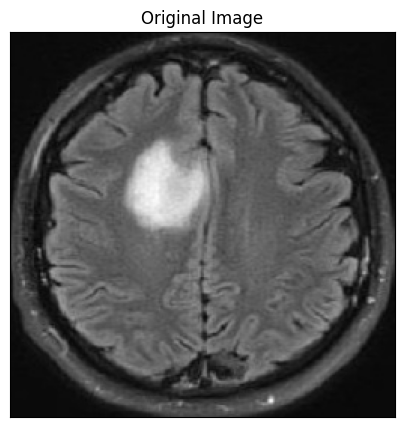

<ipython-input-19-622d92acf8bd>:84: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return mask.astype(np.bool), np.ones([mask.shape[-1]], dtype=np.int32)


Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  252.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  148.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  int64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


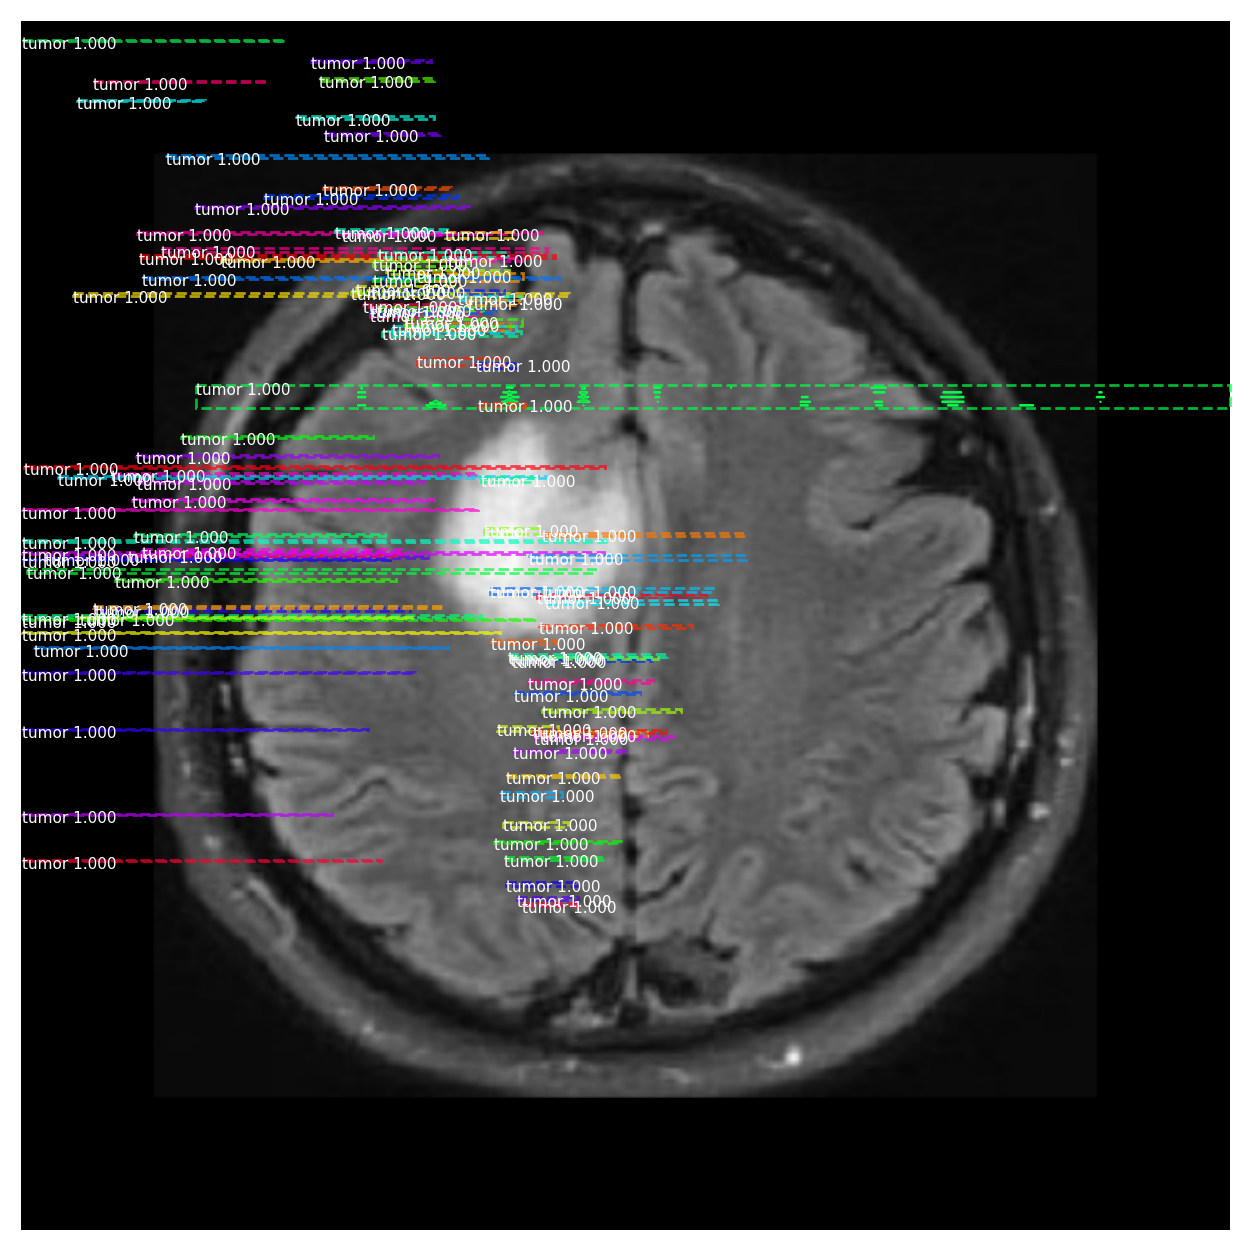

In [ ]:
ind = 0
display_image(dataset_val, ind)
predict_and_plot_differences(dataset_val, ind)

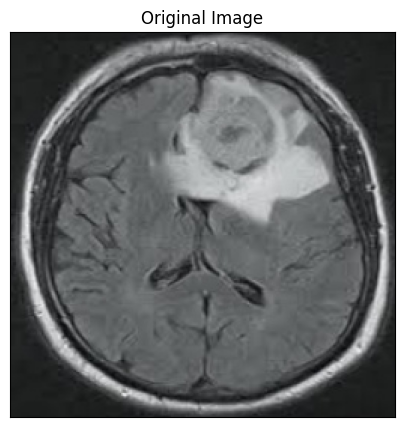

<ipython-input-19-622d92acf8bd>:84: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return mask.astype(np.bool), np.ones([mask.shape[-1]], dtype=np.int32)


Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  242.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  138.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  int64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


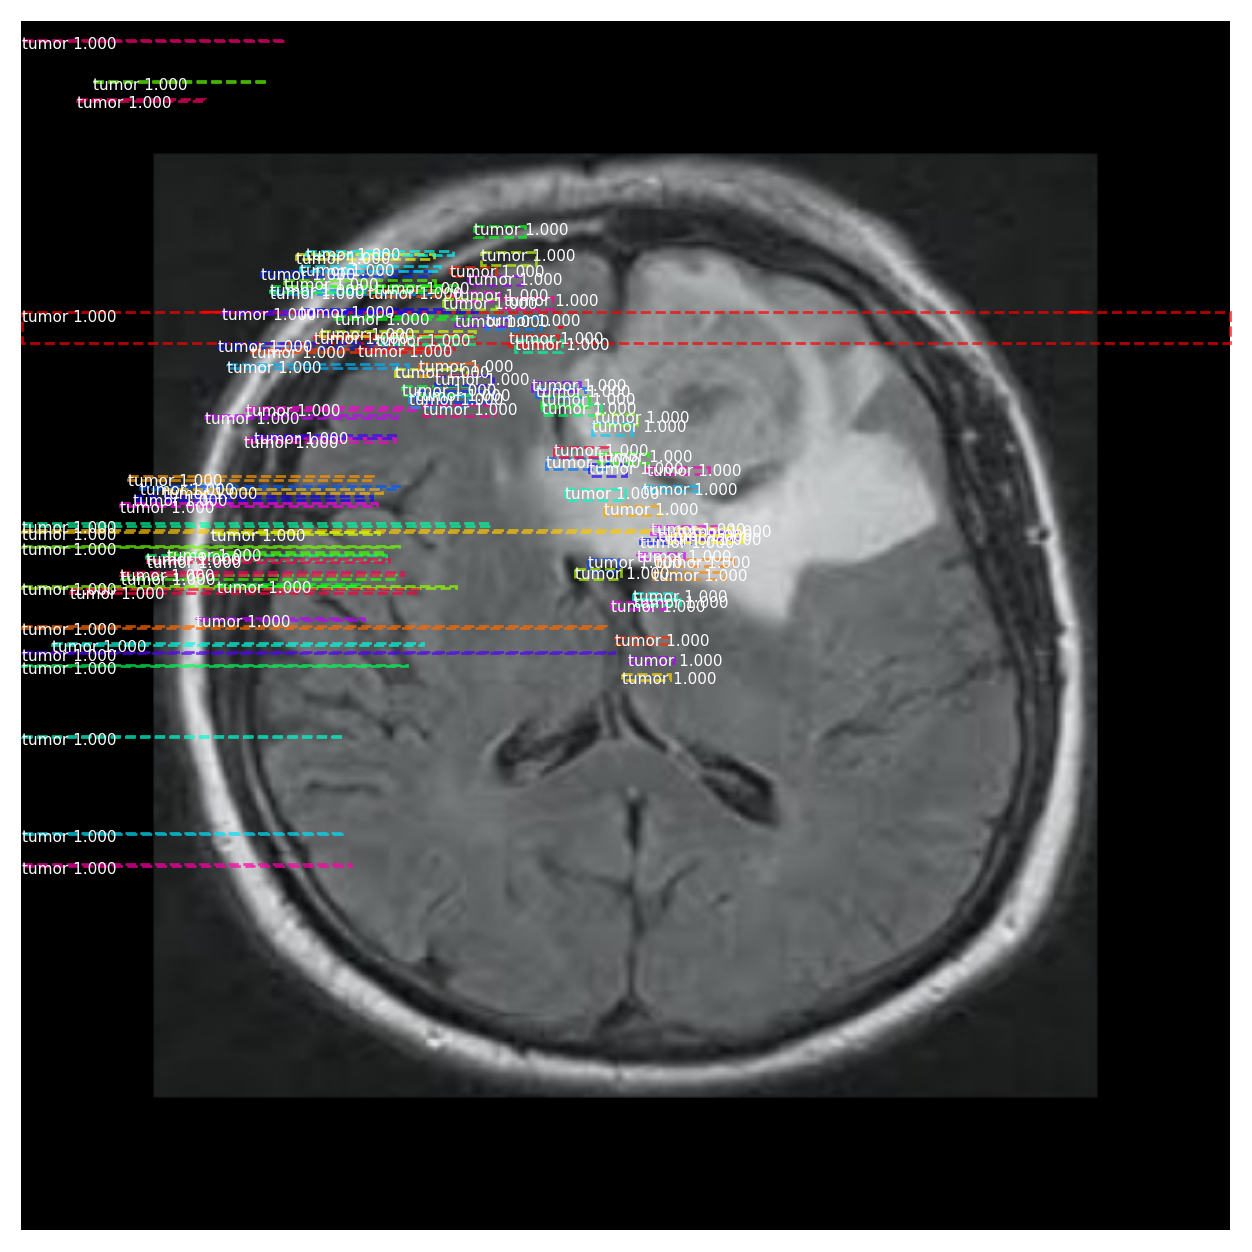

In [ ]:
ind = 10
display_image(dataset_val, ind)
predict_and_plot_differences(dataset_val, ind)

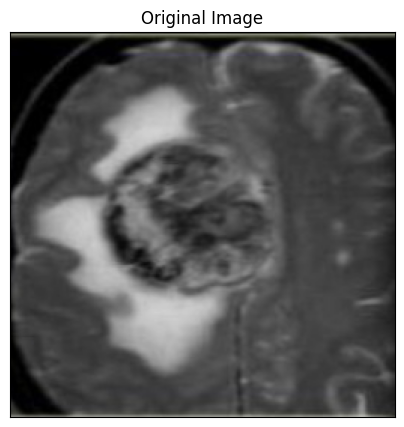

<ipython-input-19-622d92acf8bd>:84: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return mask.astype(np.bool), np.ones([mask.shape[-1]], dtype=np.int32)


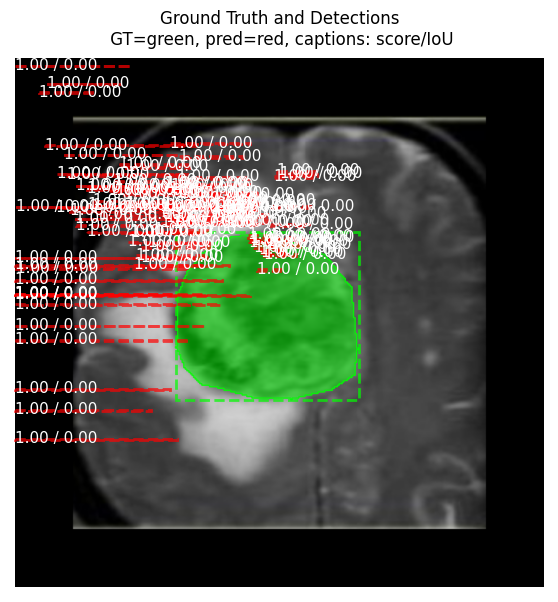

In [ ]:
ind = 4
display_image(dataset_val, ind)
predict_and_plot_differences(dataset_val, ind)

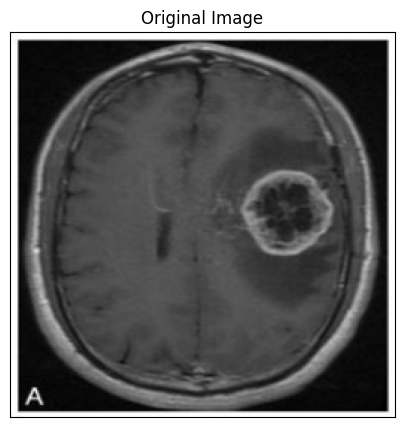

<ipython-input-24-622d92acf8bd>:84: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return mask.astype(np.bool), np.ones([mask.shape[-1]], dtype=np.int32)


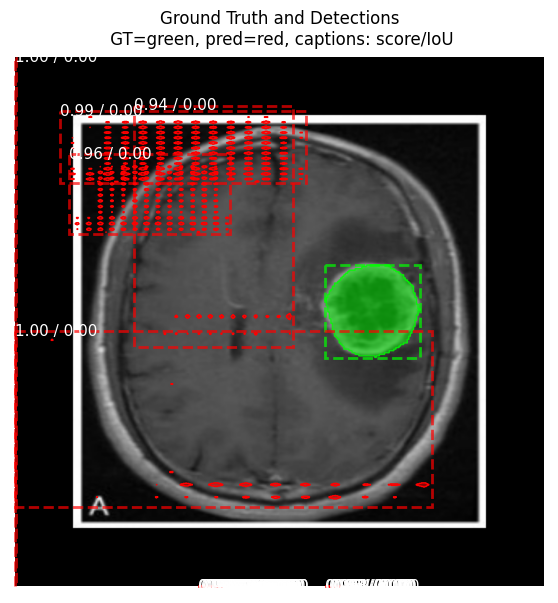

In [ ]:
ind = 0
display_image(dataset_test, ind)
predict_and_plot_differences(dataset_test, ind)

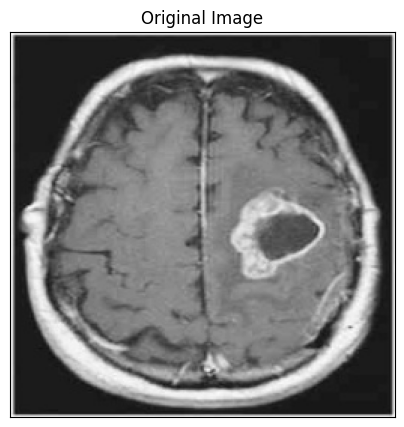

<ipython-input-24-622d92acf8bd>:84: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return mask.astype(np.bool), np.ones([mask.shape[-1]], dtype=np.int32)


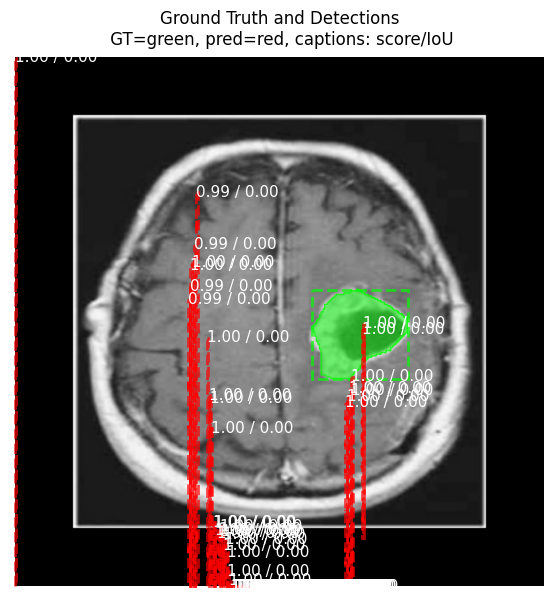

In [ ]:
ind = 3
display_image(dataset_test, ind)
predict_and_plot_differences(dataset_test, ind)

In [ ]:
# # Load a random image from the images folder
# file_names = next(os.walk(IMAGE_DIR))[2]
# image = skimage.io.imread(os.path.join(IMAGE_DIR, random.choice(file_names)))

# # Run detection
# results = model.detect([image], verbose=1)

# # Visualize results
# r = results[0]
# visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'],
#                             class_names, r['scores'])

# Background Removal

In [ ]:
# def segment(image, r):
#   idx = r['scores'].argmax()
#   mask = r['masks'][:,:,idx]
#   mask = np.stack((mask,)*3, axis=-1)
#   mask = mask.astype('uint8')
#   bg = 255 - mask * 255
#   mask_img = image*mask
#   result = mask_img+ bg
#   return result

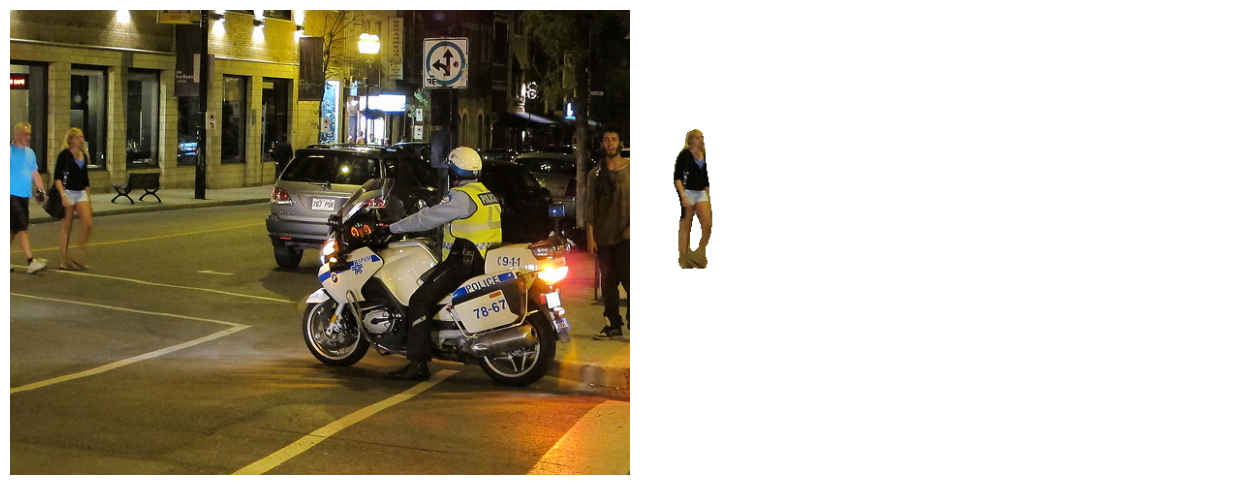

In [ ]:
# segmentation = segment(image, r)
# plt.subplots(1, figsize=(16, 16))
# plt.axis('off')
# plt.imshow(np.concatenate([image, segmentation], axis = 1))